In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from tqdm import tqdm

# Numpy 实现

In [5]:

plt.rcParams['font.sans-serif'] = ['SimHei']

mpl.rcParams['axes.unicode_minus'] = False


In [ ]:

def generate_data(n_samples=200):#sin(x) 0-2pi
    x = np.linspace(0, 2*np.pi, n_samples).reshape(-1, 1)
    x = (x - np.min(x)) / (np.max(x) - np.min(x))  #归一化
    y = np.sin(x * 2*np.pi)
    return x, y

class TwoLayerReLU:
    def __init__(self, input_size, hidden_size, output_size):
        
        self.W1 = np.random.randn(input_size, hidden_size)*np.sqrt(2.0/ input_size)#何恺明初始化
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size)* np.sqrt(2.0/ hidden_size)
        self.b2 = np.zeros((1, output_size))
        
    def forward(self, x):
        self.z1 = np.dot(x, self.W1) +self.b1
        self.a1 = np.maximum(0, self.z1)#把第一层输出Relu 
        self.z2 = np.dot(self.a1,self.W2)+ self.b2  #z2 = Relu(x*W1+b1)*W2+b2
        return self.z2
    def backward(self, x_batch, y_batch, y_pred, lr):
        m = x_batch.shape[0]#B
        dz2 = (y_pred - y_batch) / m # dloss =(y_pred- y_ture) /Batch_size  因为 loss = 1/2(y_pred-y_ture)^2
        dW2 = np.dot(self.a1.T, dz2)#∂loss/∂W2 = (∂loss/∂z2)·(∂z2/∂W2)=a1.T·dz2
        db2 = np.sum(dz2, axis=0, keepdims=True)#∂loss/∂b2 = ∂loss/∂z2 * ∂z2/∂b2 = dz2
        da1 = np.dot(dz2, self.W2.T)#∂loss/∂a1 = ∂loss/∂z2 * ∂z2/∂a1 =dz2·W2.T
        dz1 = da1 * (self.z1 > 0)#∂loss/∂z1 = ∂loss/∂a1 * ∂a1/∂z1 = da1 * (z1>0)<-Relu
        dW1 = np.dot(x_batch.T, dz1)#∂loss/∂W1 = ∂loss/∂z1 *∂z1/∂W1 = x_batch.T·dz1
        db1 = np.sum(dz1, axis=0, keepdims=True)#∂loss/∂b1 = ∂loss/∂z1 * ∂z1/∂b1 = dz1
        
        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        self.W1 -= lr * dW1
        self.b1 -= lr * db1

def train_sgd(model, x, y, batch_size=32, epochs=5000, lr=0.01, print_every=500,scheduler_step=1000,gamma=0.8):
    losses = []
    n_samples = x.shape[0]
    for epoch in range(1, epochs+1):
        indices = np.random.permutation(n_samples)
        x_shuffled = x[indices]
        y_shuffled = y[indices]
        epoch_loss = 0
        if epoch % scheduler_step == 0:
            lr*=gamma
        for i in range(0, n_samples, batch_size):
            x_batch = x_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            y_pred = model.forward(x_batch)
            loss = np.mean((y_pred - y_batch)**2)
            epoch_loss += loss * x_batch.shape[0]
            model.backward(x_batch, y_batch, y_pred, lr)
        avg_loss = epoch_loss / n_samples
        losses.append(avg_loss)
        if epoch % print_every == 0:
            print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")
    return losses


Epoch 500, Loss: 0.147648
Epoch 1000, Loss: 0.148050
Epoch 1500, Loss: 0.143703
Epoch 2000, Loss: 0.146466
Epoch 2500, Loss: 0.145479
Epoch 3000, Loss: 0.144598
Epoch 3500, Loss: 0.143308
Epoch 4000, Loss: 0.142952
Epoch 4500, Loss: 0.142163
Epoch 5000, Loss: 0.141022
Epoch 5500, Loss: 0.142172
Epoch 6000, Loss: 0.139892
Epoch 6500, Loss: 0.139383
Epoch 7000, Loss: 0.142583
Epoch 7500, Loss: 0.140823
Epoch 8000, Loss: 0.141263
Epoch 8500, Loss: 0.139714
Epoch 9000, Loss: 0.140260
Epoch 9500, Loss: 0.139651
Epoch 10000, Loss: 0.139758


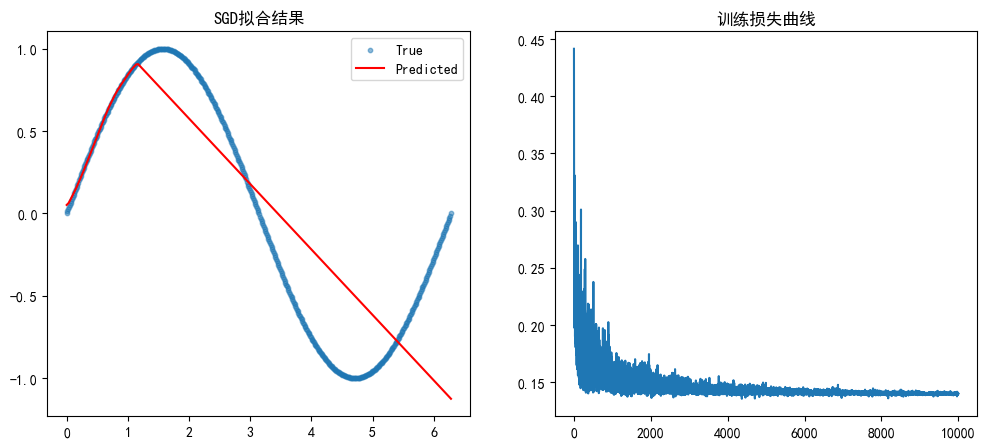

In [ ]:

x, y = generate_data(n_samples=500)
model = TwoLayerReLU(input_size=1, hidden_size=256, output_size=1)
losses = train_sgd(model, x, y, lr=0.02, epochs=10000,scheduler_step=1000,gamma=0.8)

x_test = np.linspace(0, 2*np.pi, 200).reshape(-1, 1)
x_test_norm = (x_test - np.min(x_test)) / (np.max(x_test) - np.min(x_test)) 
y_pred = model.forward(x_test_norm)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(x * 2*np.pi, y, s=10, alpha=0.5, label="True")
plt.plot(x_test, y_pred, 'r', label="Predicted")
plt.title("SGD拟合结果")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.title("训练损失曲线")
plt.show()

# Torch 实现多函数拟合

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class TwoLayersReluNN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(TwoLayersReluNN, self).__init__()
        self.fc1=nn.Linear(in_features,hidden_features)
        self.fc2=nn.Linear(hidden_features, out_features)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def sgd_train(model, optimizer, loss_fn, x, y, epochs, print_every=100,scheduler=None):
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        
        loss.backward()

        optimizer.step()
        if scheduler:
            scheduler.step()
        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(f"Epoch: {epoch+1}/{epochs}, Loss: {loss.item():.6f}")



In [ ]:

torch.manual_seed(42)

x = torch.linspace(0, 1, 100).unsqueeze(1) #(100, 1)
y_sin = torch.sin(2 * torch.pi * x)
y_exp = torch.exp(x)
y_log = torch.log(x + 1)
y_x2 = x ** 2
model = TwoLayersReluNN(in_features=1, hidden_features=512, out_features=1)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.95)
sgd_train(model, optimizer, loss_fn, x, y_sin, epochs=20000, print_every=100,scheduler=scheduler)



Epoch: 1/20000, Loss: 0.694436
Epoch: 100/20000, Loss: 0.179693
Epoch: 200/20000, Loss: 0.166338
Epoch: 300/20000, Loss: 0.153394
Epoch: 400/20000, Loss: 0.140789
Epoch: 500/20000, Loss: 0.128544
Epoch: 600/20000, Loss: 0.117347
Epoch: 700/20000, Loss: 0.106677
Epoch: 800/20000, Loss: 0.096605
Epoch: 900/20000, Loss: 0.087231
Epoch: 1000/20000, Loss: 0.078554
Epoch: 1100/20000, Loss: 0.070974
Epoch: 1200/20000, Loss: 0.064045
Epoch: 1300/20000, Loss: 0.057748
Epoch: 1400/20000, Loss: 0.052024
Epoch: 1500/20000, Loss: 0.046863
Epoch: 1600/20000, Loss: 0.042432
Epoch: 1700/20000, Loss: 0.038430
Epoch: 1800/20000, Loss: 0.034824
Epoch: 1900/20000, Loss: 0.031581
Epoch: 2000/20000, Loss: 0.028670
Epoch: 2100/20000, Loss: 0.026173
Epoch: 2200/20000, Loss: 0.023930
Epoch: 2300/20000, Loss: 0.021907
Epoch: 2400/20000, Loss: 0.020083
Epoch: 2500/20000, Loss: 0.018446
Epoch: 2600/20000, Loss: 0.017044
Epoch: 2700/20000, Loss: 0.015779
Epoch: 2800/20000, Loss: 0.014637
Epoch: 2900/20000, Loss: 0

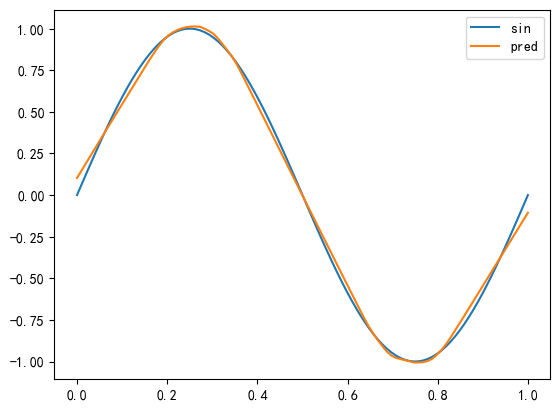

In [58]:
fig, ax = plt.subplots()
ax.plot(x, y_sin, label='sin')
ax.plot(x, model(x).detach().numpy(), label='pred')
plt.legend()
plt.show()

In [24]:

model = TwoLayersReluNN(in_features=1, hidden_features=256, out_features=1)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.9)

sgd_train(model, optimizer, loss_fn, x, y_exp, epochs=20000, print_every=100,scheduler=scheduler)



Epoch: 1/20000, Loss: 2.322732
Epoch: 100/20000, Loss: 0.057625
Epoch: 200/20000, Loss: 0.001017
Epoch: 300/20000, Loss: 0.000501
Epoch: 400/20000, Loss: 0.000392
Epoch: 500/20000, Loss: 0.000325
Epoch: 600/20000, Loss: 0.000273
Epoch: 700/20000, Loss: 0.000236
Epoch: 800/20000, Loss: 0.000206
Epoch: 900/20000, Loss: 0.000181
Epoch: 1000/20000, Loss: 0.000162
Epoch: 1100/20000, Loss: 0.000146
Epoch: 1200/20000, Loss: 0.000133
Epoch: 1300/20000, Loss: 0.000122
Epoch: 1400/20000, Loss: 0.000113
Epoch: 1500/20000, Loss: 0.000105
Epoch: 1600/20000, Loss: 0.000099
Epoch: 1700/20000, Loss: 0.000093
Epoch: 1800/20000, Loss: 0.000088
Epoch: 1900/20000, Loss: 0.000084
Epoch: 2000/20000, Loss: 0.000080
Epoch: 2100/20000, Loss: 0.000077
Epoch: 2200/20000, Loss: 0.000074
Epoch: 2300/20000, Loss: 0.000072
Epoch: 2400/20000, Loss: 0.000069
Epoch: 2500/20000, Loss: 0.000067
Epoch: 2600/20000, Loss: 0.000065
Epoch: 2700/20000, Loss: 0.000063
Epoch: 2800/20000, Loss: 0.000062
Epoch: 2900/20000, Loss: 0

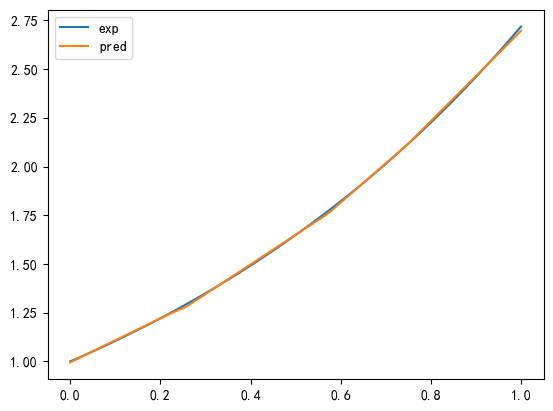

In [25]:
fig, ax = plt.subplots()
ax.plot(x, y_exp, label='exp')
ax.plot(x, model(x).detach().numpy(), label='pred')
plt.legend()
plt.show()

In [26]:

model = TwoLayersReluNN(in_features=1, hidden_features=256, out_features=1)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.9)

sgd_train(model, optimizer, loss_fn, x, y_log, epochs=20000, print_every=100,scheduler=scheduler)



Epoch: 1/20000, Loss: 0.209056
Epoch: 100/20000, Loss: 0.027916
Epoch: 200/20000, Loss: 0.007317
Epoch: 300/20000, Loss: 0.002983
Epoch: 400/20000, Loss: 0.001511
Epoch: 500/20000, Loss: 0.000842
Epoch: 600/20000, Loss: 0.000499
Epoch: 700/20000, Loss: 0.000323
Epoch: 800/20000, Loss: 0.000216
Epoch: 900/20000, Loss: 0.000147
Epoch: 1000/20000, Loss: 0.000107
Epoch: 1100/20000, Loss: 0.000079
Epoch: 1200/20000, Loss: 0.000060
Epoch: 1300/20000, Loss: 0.000047
Epoch: 1400/20000, Loss: 0.000038
Epoch: 1500/20000, Loss: 0.000031
Epoch: 1600/20000, Loss: 0.000027
Epoch: 1700/20000, Loss: 0.000023
Epoch: 1800/20000, Loss: 0.000020
Epoch: 1900/20000, Loss: 0.000018
Epoch: 2000/20000, Loss: 0.000017
Epoch: 2100/20000, Loss: 0.000015
Epoch: 2200/20000, Loss: 0.000014
Epoch: 2300/20000, Loss: 0.000013
Epoch: 2400/20000, Loss: 0.000013
Epoch: 2500/20000, Loss: 0.000012
Epoch: 2600/20000, Loss: 0.000012
Epoch: 2700/20000, Loss: 0.000011
Epoch: 2800/20000, Loss: 0.000011
Epoch: 2900/20000, Loss: 0

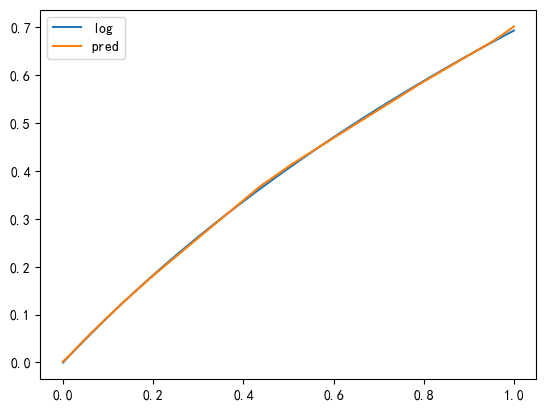

In [27]:
fig, ax = plt.subplots()
ax.plot(x, y_log, label='log')
ax.plot(x, model(x).detach().numpy(), label='pred')
plt.legend()
plt.show()


In [43]:

model = TwoLayersReluNN(in_features=1, hidden_features=256, out_features=1)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.9)

sgd_train(model, optimizer, loss_fn, x, y_x2, epochs=20000, print_every=100,scheduler=scheduler)



Epoch: 1/20000, Loss: 0.108593
Epoch: 100/20000, Loss: 0.051410
Epoch: 200/20000, Loss: 0.000920
Epoch: 300/20000, Loss: 0.000404
Epoch: 400/20000, Loss: 0.000234
Epoch: 500/20000, Loss: 0.000154
Epoch: 600/20000, Loss: 0.000110
Epoch: 700/20000, Loss: 0.000085
Epoch: 800/20000, Loss: 0.000068
Epoch: 900/20000, Loss: 0.000056
Epoch: 1000/20000, Loss: 0.000047
Epoch: 1100/20000, Loss: 0.000041
Epoch: 1200/20000, Loss: 0.000036
Epoch: 1300/20000, Loss: 0.000033
Epoch: 1400/20000, Loss: 0.000030
Epoch: 1500/20000, Loss: 0.000028
Epoch: 1600/20000, Loss: 0.000026
Epoch: 1700/20000, Loss: 0.000025
Epoch: 1800/20000, Loss: 0.000024
Epoch: 1900/20000, Loss: 0.000023
Epoch: 2000/20000, Loss: 0.000022
Epoch: 2100/20000, Loss: 0.000021
Epoch: 2200/20000, Loss: 0.000021
Epoch: 2300/20000, Loss: 0.000020
Epoch: 2400/20000, Loss: 0.000020
Epoch: 2500/20000, Loss: 0.000020
Epoch: 2600/20000, Loss: 0.000019
Epoch: 2700/20000, Loss: 0.000019
Epoch: 2800/20000, Loss: 0.000019
Epoch: 2900/20000, Loss: 0

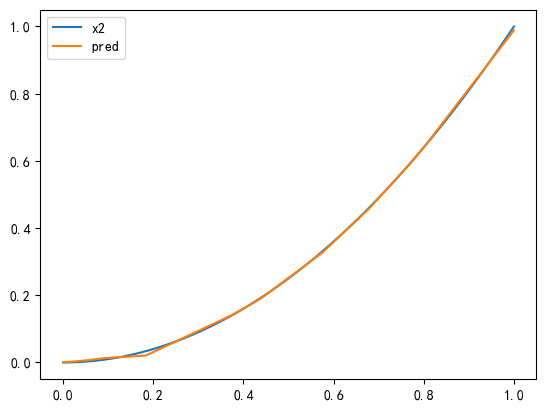

In [44]:
fig, ax = plt.subplots()
ax.plot(x, y_x2, label='x2')
ax.plot(x, model(x).detach().numpy(), label='pred')
plt.legend()
plt.show()


In [51]:

model = TwoLayersReluNN(in_features=1, hidden_features=512, out_features=1)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)
y_func = y_sin + y_exp - y_log - y_x2
sgd_train(model, optimizer, loss_fn, x, y_func, epochs=30000, print_every=100,scheduler=scheduler)



Epoch: 1/30000, Loss: 2.177226
Epoch: 100/30000, Loss: 0.475633
Epoch: 200/30000, Loss: 0.175172
Epoch: 300/30000, Loss: 0.122884
Epoch: 400/30000, Loss: 0.079733
Epoch: 500/30000, Loss: 0.052384
Epoch: 600/30000, Loss: 0.034322
Epoch: 700/30000, Loss: 0.023895
Epoch: 800/30000, Loss: 0.017387
Epoch: 900/30000, Loss: 0.013300
Epoch: 1000/30000, Loss: 0.010829
Epoch: 1100/30000, Loss: 0.008911
Epoch: 1200/30000, Loss: 0.007419
Epoch: 1300/30000, Loss: 0.006374
Epoch: 1400/30000, Loss: 0.005527
Epoch: 1500/30000, Loss: 0.004835
Epoch: 1600/30000, Loss: 0.004304
Epoch: 1700/30000, Loss: 0.003849
Epoch: 1800/30000, Loss: 0.003442
Epoch: 1900/30000, Loss: 0.003123
Epoch: 2000/30000, Loss: 0.002844
Epoch: 2100/30000, Loss: 0.002602
Epoch: 2200/30000, Loss: 0.002411
Epoch: 2300/30000, Loss: 0.002242
Epoch: 2400/30000, Loss: 0.002093
Epoch: 2500/30000, Loss: 0.001972
Epoch: 2600/30000, Loss: 0.001862
Epoch: 2700/30000, Loss: 0.001763
Epoch: 2800/30000, Loss: 0.001680
Epoch: 2900/30000, Loss: 0

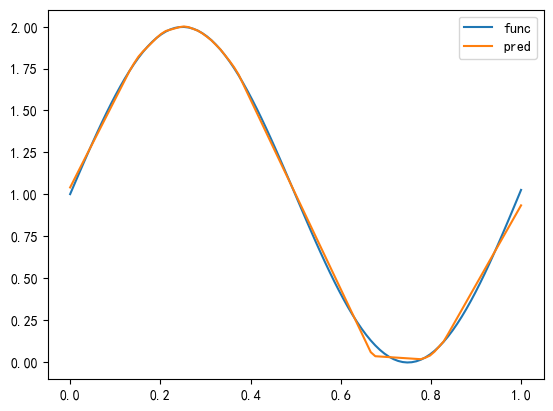

In [52]:
fig, ax = plt.subplots()
ax.plot(x, y_func, label='func')
ax.plot(x, model(x).detach().numpy(), label='pred')
plt.legend()
plt.show()
